In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split
import missingno as msno

In [3]:
lastfm_df = pd.read_csv("/Users/polina/PycharmProjects/recommendation_system/recommendation-system/data/external/lastfm_1k/userid-timestamp-artid-artname-traid-traname.tsv", sep='\t',  header=None,
    names=[
        'user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name'
    ], skiprows=[
        2120260-1, 2446318-1, 11141081-1,
        11152099-1, 11152402-1, 11882087-1,
        12902539-1, 12935044-1, 17589539-1
    ])

In [4]:
%md
## dataset overview and descriptive statistics

UsageError: Line magic function `%md` not found.


In [4]:
lastfm_df.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [5]:
lastfm_df.shape

(19098853, 6)

In [6]:
lastfm_df.dtypes

user_id        object
timestamp      object
artist_id      object
artist_name    object
track_id       object
track_name     object
dtype: object

In [7]:
lastfm_df[lastfm_df.duplicated()]

,user_id,timestamp,artist_id,artist_name,track_id,track_name
5307317,user_000274,2008-10-31T21:52:29Z,6e913bad-4812-4286-b6cc-18548422f194,John Foxx,f8317357-7fea-47d4-9e2f-3fe91ef349c9,He'S A Liquid (Alternative Version)


In [8]:
lastfm_df.isna().sum()

user_id              0
timestamp            0
artist_id       600848
artist_name          0
track_id       2162719
track_name         210
dtype: int64

<AxesSubplot:>

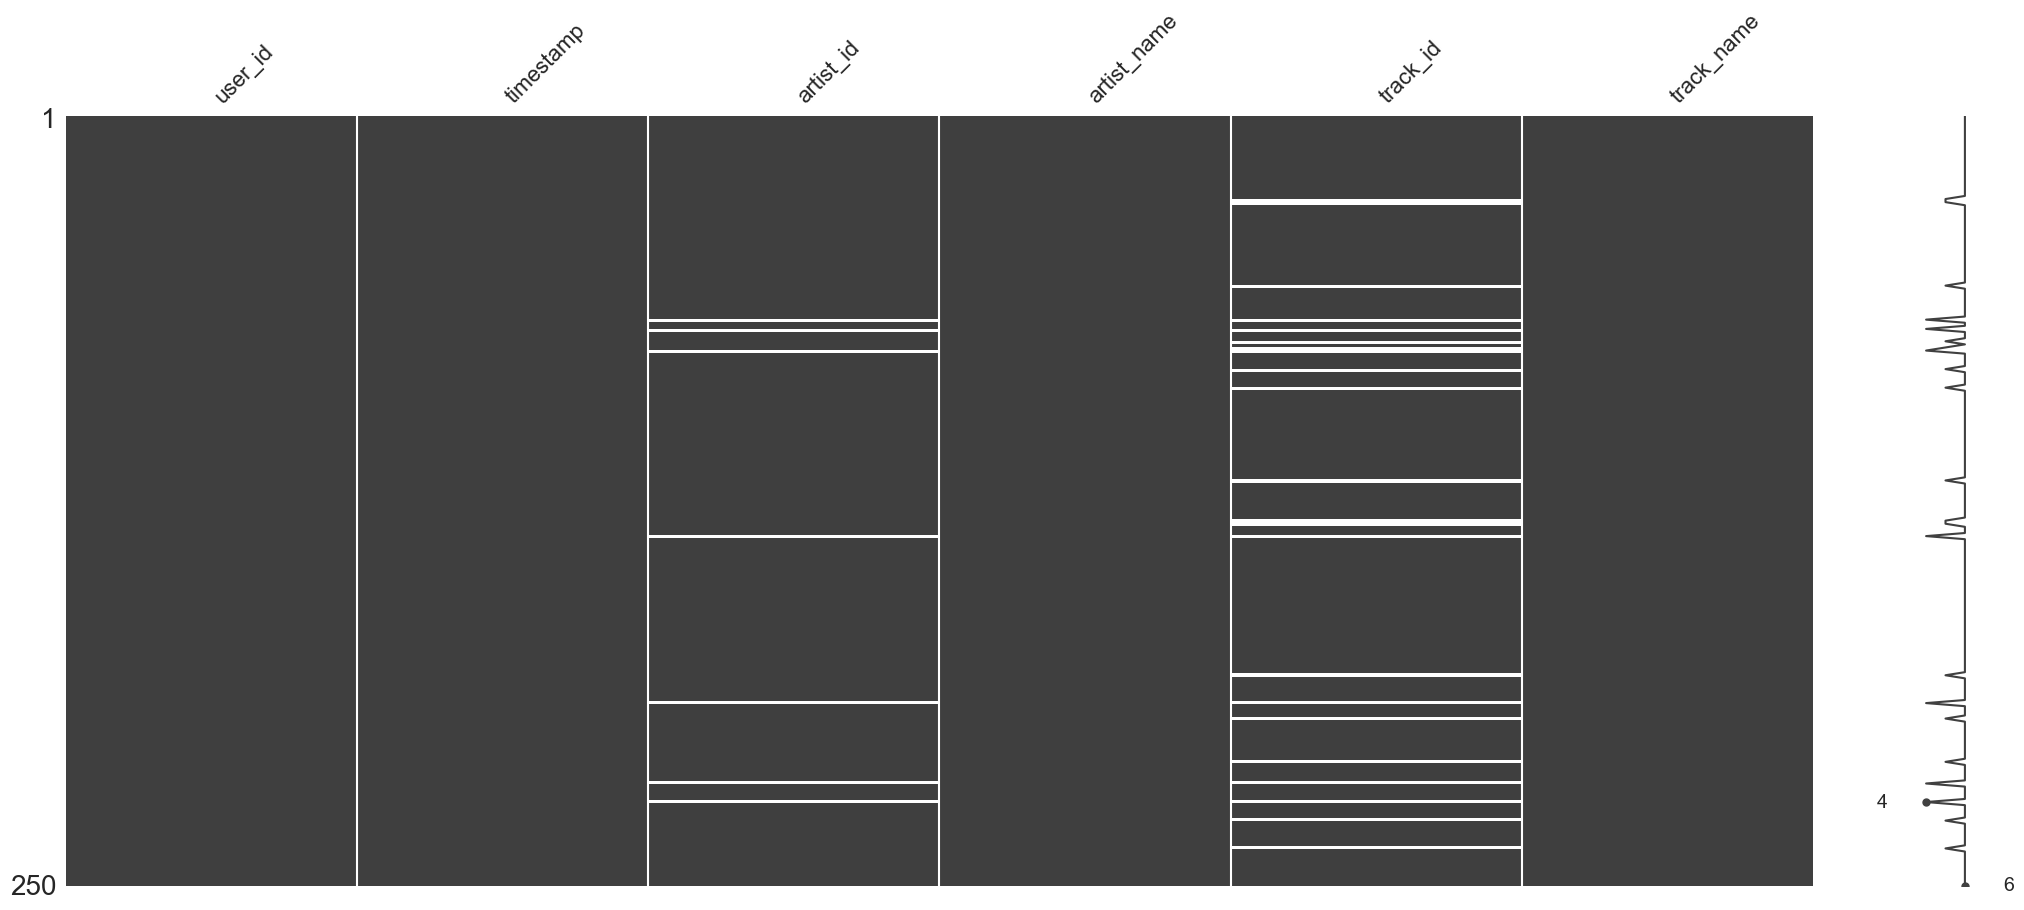

In [9]:
msno.matrix(lastfm_df.sample(250))

<AxesSubplot:>

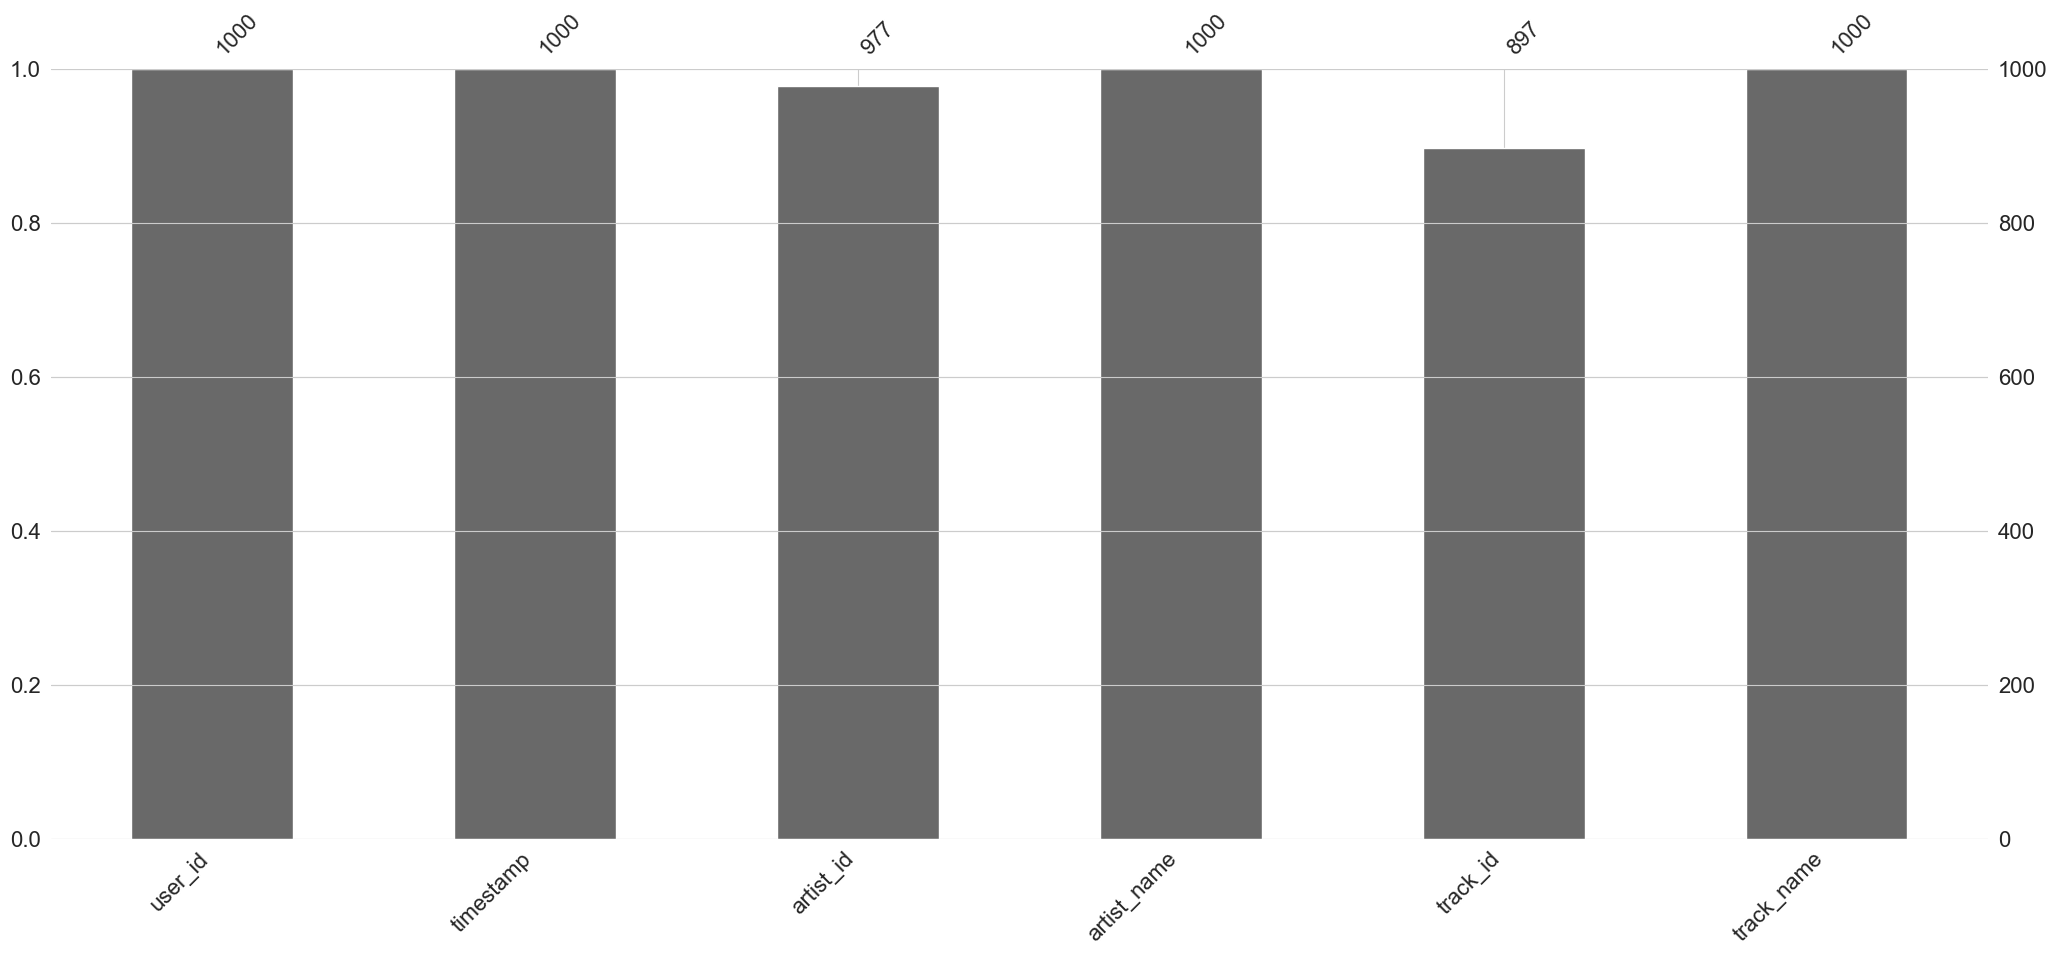

In [10]:
msno.bar(lastfm_df.sample(1000))

<AxesSubplot:>

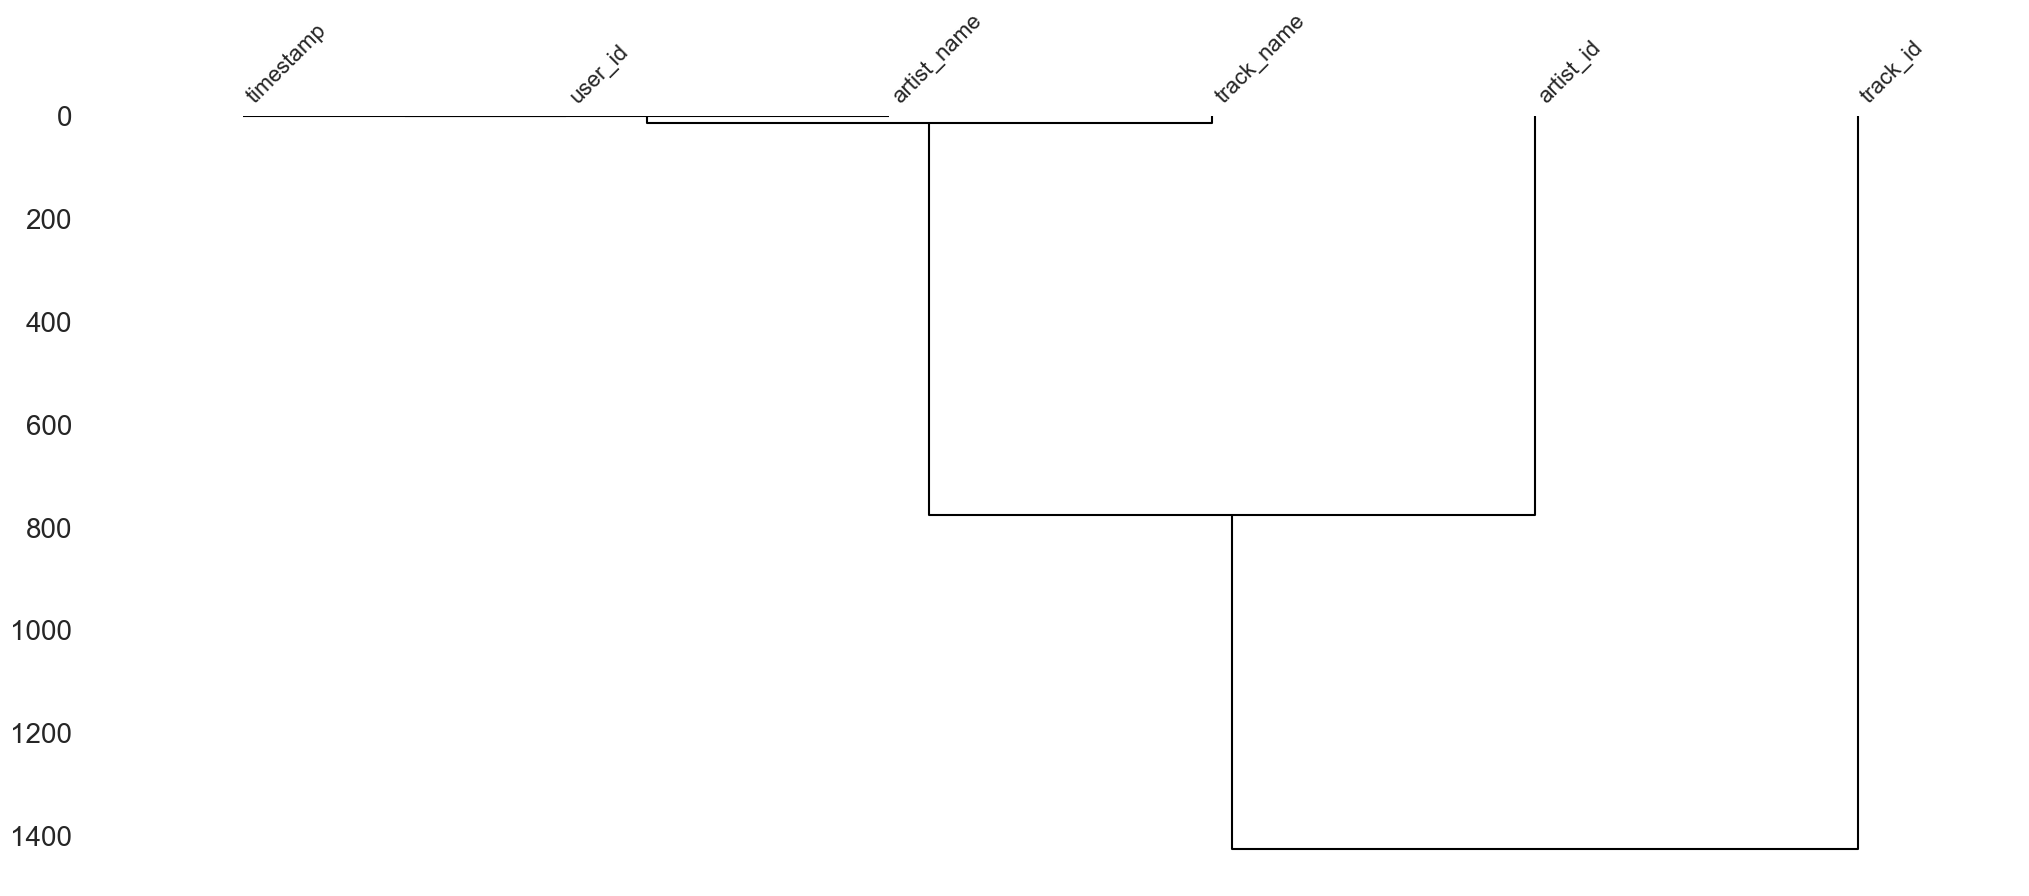

In [11]:
msno.dendrogram(lastfm_df)

In [12]:
categorical_features = lastfm_df.select_dtypes(include=[np.object])

categorical_features.columns

/var/folders/t7/mc9xrfld1mb9_gqcpt1_s78h0000gn/T/ipykernel_20991/606757311.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = lastfm_df.select_dtypes(include=[np.object])


Index(['user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id',
       'track_name'],
      dtype='object')

In [13]:
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19098853 entries, 0 to 19098852
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   timestamp    object
 2   artist_id    object
 3   artist_name  object
 4   track_id     object
 5   track_name   object
dtypes: object(6)
memory usage: 874.3+ MB


In [32]:
len(categorical_features['user_id']), categorical_features['user_id'].nunique()

(19098853, 992)

In [20]:
len(categorical_features['artist_id']), categorical_features['artist_id'].nunique()

(19098853, 107295)

In [21]:
len(categorical_features['track_id']), categorical_features['track_id'].nunique()

(19098853, 960402)

In [33]:
tracks_repeats = categorical_features.groupby('track_id')['track_id'].count()
tracks_repeats.sort_values(ascending=False)

track_id
db16d0b3-b8ce-4aa8-a11a-e4d53cc7f8a6    3991
7f1f45c0-0101-49e9-8d69-23951d271163    3651
9e2ad5bc-c6f9-40d2-a36f-3122ee2072a3    3533
4e17b118-70a6-4c1f-b326-b4ce91fd3fad    3479
ff1e3e1a-f6e8-4692-b426-355880383bb6    3463
                                        ... 
65836d80-23f4-433e-88e5-068df75550c5       1
65837273-31f1-4b3a-9949-10fc15f16943       1
6583cc1c-8922-4b94-b073-4f95ab4b362f       1
6583ddb9-7c95-4420-8cd5-df4dfdae11ae       1
ffffff64-4a90-4350-9281-c9dc10aa9d30       1
Name: track_id, Length: 960402, dtype: int64

In [34]:
tracks_repeats = categorical_features.groupby('artist_id')['artist_id'].count()
tracks_repeats.sort_values(ascending=False)

artist_id
a74b1b7f-71a5-4011-9441-d0b5e4122711    115099
b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d    100126
b7ffd2af-418f-4be2-bdd1-22f8b48613da     84317
9c9f1380-2516-4fc9-a3e6-f9f61941d090     63139
cc197bad-dc9c-440d-a5b5-d52ba2e14234     62212
                                         ...  
8d9765a7-280a-4b39-8d4e-96bb8efb1b2e         1
8d8a6666-35a4-4af8-9d34-9ba2a2ea41c0         1
8d85e22e-d4ba-4a57-b827-deb96d66ff64         1
8d828fe5-3bf8-4dc2-aa2d-2bb8e6e0fd30         1
ffff44bd-e5a5-4e87-8700-35481264e37d         1
Name: artist_id, Length: 107295, dtype: int64

In [42]:
user_repeats = categorical_features[['user_id', 'track_id']].groupby('user_id').count().reset_index()
user_repeats.columns = ['user_id', 'n_sessions']
user_repeats.head()

,user_id,n_sessions
0,user_000001,11950
1,user_000002,53429
2,user_000003,17552
3,user_000004,16322
4,user_000005,15400


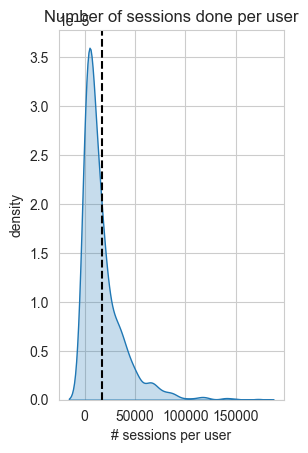

In [46]:
plt.subplot(1,2,2)
ax = sns.kdeplot(user_repeats['n_sessions'], fill=True, legend=False)
plt.axvline(user_repeats['n_sessions'].mean(), color="k", linestyle="--")
plt.xlabel("# sessions per user")
plt.ylabel("density")
plt.title("Number of sessions done per user")
plt.show()